#  AIG 100 | Project 3 | Customer segmentation for targeted marketing |

## Introduction

### Objective
* Use Gaussian Mixture Models to cluster customers into segments for targeted marketing. 

### About

I want to  use machine learning to analyze customer purchasing behavior and automatically segment them into distinct groups — without human labels. This helps:

1. Marketing Strategy
- Identify high-value customers → Offer loyalty rewards or upsell

- Spot at-risk or dormant users → Re-engagement campaigns

- Segment for personalized offers

2. Product Insights
- Which types of users prefer which products 

3. Business Intelligence
- Provides actionable insights on customer lifetime value, purchasing habits, and more


## Data Cleaning and preporcessing

- Data Source : [Online retail customer](https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering)

### Dataset Description

The dataset contains transactional data from a UK-based online retailer, comprising:

InvoiceNo: Unique invoice identifier

StockCode: Product identifier

Description: Product name

Quantity: Number of products purchased

InvoiceDate: Date and time of transaction

UnitPrice: Price per product

CustomerID: Unique customer identifier

Country: Country of purchase

### Load Data

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns



In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
import pandas as pd

# Load the uploaded CSV file
file_path = "OnlineRetail.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


In [77]:
df.shape


(541909, 8)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [79]:
#numerical stats
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [80]:
#missing values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Removing empty rows

In [81]:
df = df.dropna(subset=['CustomerID'])

In [82]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Calculating total price 

In [83]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

### Converting InvoiceDate to valid datetime

In [84]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True,  format='mixed')

In [85]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

### Removing Outliers

In [86]:
# Columns to check for outliers
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']

# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df

df = remove_outliers_iqr(df, numeric_cols)

In [87]:
df.shape

(330007, 9)

### Creating RFM Table

RFM stands for:

 - Recency	How recently a customer made a purchase (lower is better) 
 - Frequency	How often a customer makes purchases (higher is better)
 - Monetary	How much money a customer has spent (higher is better)


In [88]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

In [89]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,2783.37
12348.0,249,3,90.20
12349.0,19,1,939.75
12350.0,310,1,294.40
12352.0,36,8,1101.09
...,...,...,...
18280.0,278,1,137.00
18281.0,181,1,46.92
18282.0,8,3,111.68


## Exploratory Data Visualization

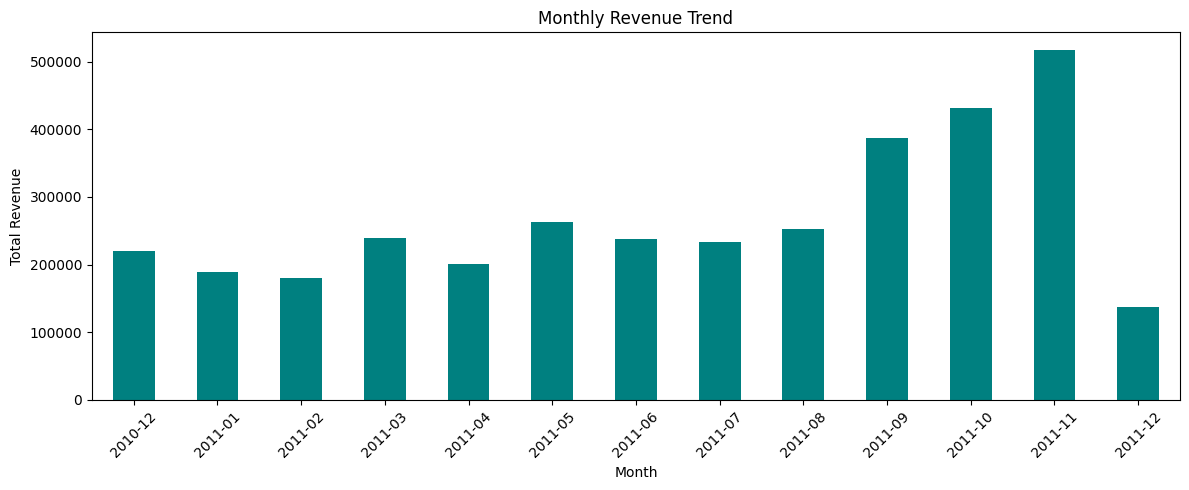

In [91]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(12, 5))
monthly_revenue.plot(kind='bar', color='teal')
plt.title("Monthly Revenue Trend")
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### The above Graph shows 
 - September, October, November are the month which brings the most revenue 
 - August is the month where business has to prepare(collect high stocks) for the peak sales


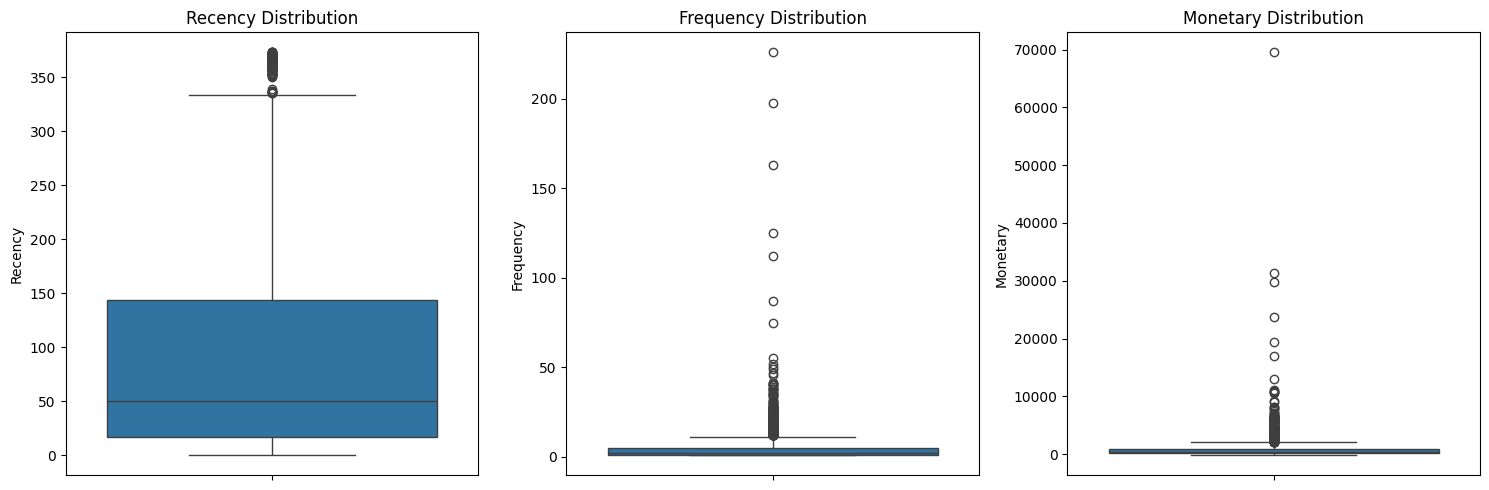

In [92]:
rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

plt.figure(figsize=(15, 5))
for i, col in enumerate(rfm_data.columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=rfm_data[col])
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

#### The above Graph shows

##### For recency distribution
- Low Recency (bottom of box): More recent, active customers.
- High Recency (top, right-side whiskers): Customers who haven’t purchased in a long time.
- The box (interquartile range, IQR) shows that most customers have Recency between ~20 to ~150 days.
- Outliers above 300 days are very inactive customers.

##### For frequency distribution
- The box shows most customers made fewer than 5 purchases.
- Many outliers go up to 250 purchases .
- The median (line inside box) is very low → most customers only ordered once or twice.

##### For Monetary Distribution
- Most customers spent under 2,000 .
- Several large spikes above 50K and even 250K.
- The majority of customers are low-to-mid spenders.

### Scaling features

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(rfm_scaled, test_size=0.3, random_state=7)

### Calculating Silhoutte Score to determine optimal number of clusters

In [95]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=7)
    gmm.fit(X_train)
    labels = gmm.predict(X_train)
    score = silhouette_score(X_train, labels)
    sil_scores.append(score)

In [96]:
sil_scores

[0.3846617992800311,
 0.20078007686674043,
 0.126774920356974,
 0.1176980323344496,
 0.20477979643006264,
 0.20477847831555468,
 0.21060930948802156,
 0.2198108324268307]

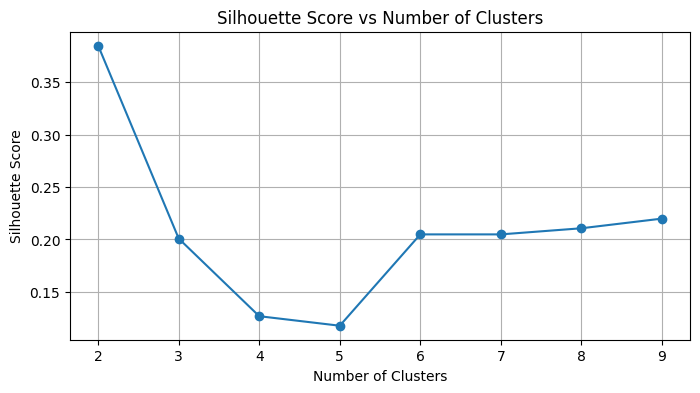

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### Choosing best silhoutte score

In [98]:
import numpy as np

best_k = np.argmax(sil_scores) + 2
gmm = GaussianMixture(n_components=best_k, random_state=7)
gmm.fit(X_train)

GaussianMixture(n_components=2, random_state=7)

### Predict clusters for training and testing

In [99]:
train_labels = gmm.predict(X_train)
test_labels = gmm.predict(X_test)

### Model Evaluation

In [100]:
train_score = silhouette_score(X_train, train_labels)
test_score = silhouette_score(X_test, test_labels)

print(f"Silhouette Score (Train): {train_score:.3f}")
print(f"Silhouette Score (Test): {test_score:.3f}")

Silhouette Score (Train): 0.385
Silhouette Score (Test): 0.369


#### Evaluation  
Score Range:
+1 = Perfect clustering (well separated)

0 = Overlapping clusters (ambiguous)

-1 = Misclassified (point is closer to another cluster than its own)

The model scores:
- Train: 0.370

- Test: 0.402

The above scores represents:
-  clusters are reasonably well-formed

- There's some overlap, but also a clear distinction between segments

In [101]:
rfm['Cluster'] = gmm.fit_predict(rfm_scaled)

### PCA for visualization

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = components[:, 0]
rfm['PCA2'] = components[:, 1]

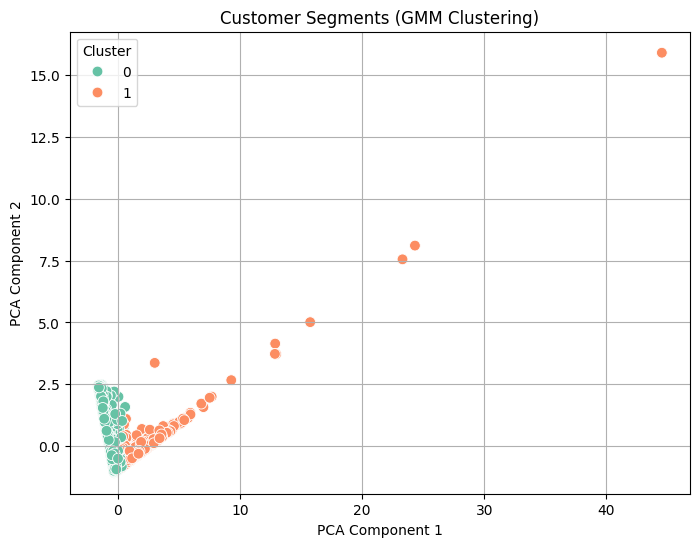

In [103]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title("Customer Segments (GMM Clustering)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### Cluster 1 (Orange, Left Dense Group)
These customers are densely packed near the origin, suggesting:

 - Low monetary value

- Low frequency

- Possibly recent or inactive

- Likely represents the majority low-value customers

#### Cluster 0 (Green, Spread Out)
More spread out and extends across both components

- Includes customers with:

- High spending

- High order frequency

- Long-term or recurring activity

- This is likely your high-value customer group

## Result Interpretation

The GMM-based customer segments shown in PCA space consist of a wide cluster containing small-value customers alongside a loosely distributed cluster having higher-value customers. The division of customers into specific groups creates better options for targeted advertising and resource management.

## Model Selection

I selected the Gaussian Mixture Model (GMM) for clustering due to
-  its flexibility and ability to model clusters. 
- GMM supports different covariance structures that help the model adapt according to the natural cluster spread and cluster density. 
- This makes GMM particularly well-suited for clustering customers based on Recency, Frequency, and Monetary (RFM) values.

## Real-World Implications

This method helps the business to:

- The business should offer exclusive benefits alongside discounts to its most valued VIP customers who belong to Cluster 0.

- The company should direct re-engagement campaigns to revive dormant customers who belong to Cluster 1.

- Businesses should direct their marketing funds toward segments that bring maximum value.

- Personalize user experiences based on behavioral profiles


## Addressing Overfitting

- Avoided overfitting using silhouette analysis

- Used different covariance_type options in GMM to limit model flexibility

- Train/test split helped validate cluster consistency

## Conclusion

This implementaion of clustering technique moderately segments customers by their purchasing behavior patterns. The findings from this analysis provide essential guidance to direct marketing and retention strategies at the organizational or group level. The capabilities of clustering demonstrated its ability to extract hidden patron patterns from buying data through unsupervised analysis.

## Reflection

#### Challenges : Solutions
-  Missing data : Missing data were mostly from the column CustomerID, which is the one of the important column for this project, so i removed all the row whose data were missing from the column
- feature selection : I had to research a lot how can we implement a good clustering method, for that feature selection was very important, so i created RFM(Recency, Frequency and Monetary) table to better align the clustering
- Cluster Understanding :  Translating the clusters into meaningful business segments which required domain knowledge and thoughtful interpretation of the RFM features.

## Tools and References

Python (Pandas, Scikit-learn, Seaborn, Matplotlib)

Blogs:

- Towards Data Science: GMM vs KMeans

- Analytics Vidhya: Customer Segmentation with RFM

GenAI Tools:

- ChatGPT 

